<h1><p><center style="background: linear-gradient(to right,white,blue);color: transparent;font-family: Gabriola;color: navy;font-size: 210%;text-align: center;border-radius: 10px 70px">
   Predict Price Car 🚗
</center></p></h1>

![car](https://i.ytimg.com/vi/S7z7azrCoL0/maxresdefault.jpg)

<a class="anchor" id="about_dataset"></a>
<br>
<br>
<br>
<font style="font-family:Gabriola; font-size:300%;">1️⃣ Step 1 | Data Cleaning </font><br>
 <br>   
<br>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import (
    train_test_split,
)

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import re
from hazm import Normalizer, stopwords_list
import matplotlib.pyplot as plt

In [81]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [83]:
train_data['volume'] = train_data['volume'].str.extract(r'(\d+(\.\d+)?)')[0].astype(float)
test_data['volume'] = test_data['volume'].str.extract(r'(\d+(\.\d+)?)')[0].astype(float)

In [84]:
normalizer = Normalizer()

In [85]:
def text_cleaning(text):
    if isinstance(text, str):
        text = normalizer.normalize(text)
        text = re.sub(r"[^ا-ی0-9a-zA-Z\s]", "", text)
        text = " ".join(
            [word for word in text.split() if word not in stopwords_list()]
        )
        return text
    return ""

In [86]:
def clean_numeric(value):
    if isinstance(value, str):
        value = value.replace(" km", "").replace(",", "")
        try:
            return float(value)
        except ValueError:
            return np.nan
    return value

In [87]:
train_data["mileage"] = train_data["mileage"].apply(
    clean_numeric
)

In [88]:
train_data["year"] = train_data["year"].astype(int)
# train_data["acceleration"] = train_data["acceleration"].apply(
#     clean_numeric
# )

In [89]:
test_data["year"] = test_data["year"].astype(int)
# test_data["acceleration"] = test_data["acceleration"].apply(
#     clean_numeric
# )

In [90]:
test_data['acceleration'] = test_data['acceleration'].str.replace(' ثانیه', '', regex=False)

test_data['acceleration'] = test_data['acceleration'].str.replace('/', '.', regex=False)

test_data['acceleration'] = pd.to_numeric(test_data['acceleration'], errors='coerce')

In [91]:
train_data['acceleration'] = train_data['acceleration'].str.replace(' ثانیه', '', regex=False)

train_data['acceleration'] = train_data['acceleration'].str.replace('/', '.', regex=False)

train_data['acceleration'] = pd.to_numeric(train_data['acceleration'], errors='coerce')

In [92]:
train_data

,title,year,mileage,transmission,fuel,body_color,inside_color,body_status,description,body_type,volume,engine,acceleration,price
0,هیوندای، توسان,2014,175000.0,اتوماتیک,9.6 لیتر در صد کیلومتر,سفید,مارون,بدون رنگ,مانیتور اندرویدی بدنه بدون لیسه کشی و روغن گیر...,crossover,2.4,4 سیلندر,10.4,"2,550,000,000"
1,پراید، 131,1391,330000.0,دنده ای,6.7 لیتر در صد کیلومتر,سفید,سفید,بدون رنگ,ماشین شاستی سرشاستی پلمپ میباشد به شرط موتوری ...,passenger_car,1.3,4 سیلندر یورو3 (M13),13.8,"215,000,000"
2,پژو، 206,1398,132000.0,دنده ای,6.4 لیتر در صد کیلومتر,سفید,خاکستری,بدون رنگ,خیلی تمیز فنی عالی,hatchback,1.4,4 سیلندر TU3,14.1,"445,000,000"
3,تیبا، هاچ بک,1396,103000.0,دنده ای,6.9 لیتر در صد کیلومتر,آبی,خاکستری,بدون رنگ,ماشین دارای دوربین دنده عقب،روکش صندلی نو،زاپا...,hatchback,1.5,4 سیلندر M15,13.0,"310,000,000"
4,پژو، پارس,1401,37000.0,دنده ای,7 لیتر در صد کیلومتر,خاکستری,کرم,بدون رنگ,NaN,passenger_car,1.8,4 سیلندر XU7 پلاس,12.0,"570,000,000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15583,رانا، LX,1392,230000.0,دنده ای,6.9 لیتر در صد کیلومتر,قرمز,مشکی,چند لکه رنگ,موتور تازه تعمیر \r\nلاستیک نو,passenger_car,1.6,4 سیلندر TU5 یورو4,12.0,"280,000,000"
15584,رانا، پلاس,1401,50000.0,دنده ای,6.9 لیتر در صد کیلومتر,مشکی,مشکی,بدون رنگ,NaN,passenger_car,1.6,4 سیلندر TU5 یورو5,12.0,"495,000,000"
15585,پژو، 207,1402,9500.0,دنده ای,6.6 لیتر در صد کیلومتر,مشکی,مشکی,بدون رنگ,NaN,hatchback,1.6,4 سیلندر TU5,11.6,"710,000,000"
15586,سیتروئن، زانتیا,1388,178000.0,دنده ای,7 لیتر در صد کیلومتر,سفید,خاکستری,چند لکه رنگ,ماشین فوق‌العاده تمیز و سالم فنی کاملا سالم و ...,passenger_car,2.0,4 سیلندر XU10,9.5,"650,000,000"


In [94]:
test_data["mileage"] = test_data["mileage"].apply(
    clean_numeric
)

In [95]:
test_data["year"] = test_data["year"].astype(int)
test_data["acceleration"] = test_data["acceleration"].apply(
    clean_numeric
)

In [96]:
train_data = train_data[
    train_data["price"].apply(
        lambda x: isinstance(x, str) and x.replace(",", "").isdigit()
    )
]

In [97]:
train_data["price"] = (
    train_data["price"].str.replace(",", "").astype(float)
)

C:\Users\peyman\AppData\Local\Temp\ipykernel_11696\780046509.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["price"] = (


In [98]:
print(train_data.isnull().sum())
train_data.fillna(
    {"fuel": "نامشخص", "engine": "نامشخص", "description": "", "acceleration": 0},
    inplace=True,
)

title              0
year               0
mileage          272
transmission       0
fuel            1656
body_color         0
inside_color       0
body_status        0
description     2098
body_type          0
volume          1216
engine          1216
acceleration    1835
price              0
dtype: int64


C:\Users\peyman\AppData\Local\Temp\ipykernel_11696\1096579500.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.fillna(


In [103]:
train_data=train_data[['title','year','mileage','transmission','fuel','body_color','inside_color',
                       'body_status','body_type','volume','engine','acceleration','price']]

In [26]:
a = list(train_data['transmission'].unique())
b = len(a)
c =[]
for i in range(b):
    c.append(i)


In [27]:
train_data.transmission = train_data.transmission.map(dict(zip(a,c)))

In [28]:
def tran(f):
    a = list(train_data[f].unique())
    b = len(a)
    c =[]
    for i in range(b):
        c.append(i)
    return a,c

    

In [29]:
a,c = tran('title')

In [30]:
train_data.title = train_data.title.map(dict(zip(a,c)))

In [31]:
a,c = tran('body_color')
train_data.body_color = train_data.body_color.map(dict(zip(a,c)))

In [32]:
a,c = tran('inside_color')
train_data.inside_color = train_data.inside_color.map(dict(zip(a,c)))

In [33]:
a,c = tran('body_status')
train_data.body_status = train_data.body_status.map(dict(zip(a,c)))

In [34]:
a,c = tran('body_type')
train_data.body_type = train_data.body_type.map(dict(zip(a,c)))  

In [35]:
# a,c = tran('engine')
# train_data.body_type = train_data.engine.map(dict(zip(a,c))) 

In [36]:
# a,c = tran('fuel')
# train_data.body_type = train_data.fuel.map(dict(zip(a,c))) 

In [37]:
a = list(train_data['engine'].unique())
b = len(a)
c =[]
for i in range(b):
    c.append(i)
train_data.engine = train_data.engine.map(dict(zip(a,c)))

In [39]:
a = list(train_data['fuel'].unique())
b = len(a)
c =[]
for i in range(b):
    c.append(i)
train_data.fuel = train_data.fuel.map(dict(zip(a,c)))

In [42]:
train_data

,title,year,mileage,transmission,fuel,body_color,inside_color,body_status,body_type,volume,engine,acceleration,price
0,0,2014,175000.0,0,0,0,0,0,0,2.4,0,10.4,2.550000e+09
1,1,1391,330000.0,1,1,0,1,0,1,1.3,1,13.8,2.150000e+08
2,2,1398,132000.0,1,2,0,2,0,2,1.4,2,14.1,4.450000e+08
3,3,1396,103000.0,1,3,1,2,0,2,1.5,3,13.0,3.100000e+08
4,4,1401,37000.0,1,4,2,3,0,1,1.8,4,12.0,5.700000e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15583,19,1392,230000.0,1,3,8,4,8,1,1.6,16,12.0,2.800000e+08
15584,118,1401,50000.0,1,3,3,4,0,1,1.6,55,12.0,4.950000e+08
15585,6,1402,9500.0,1,6,3,4,0,2,1.6,6,11.6,7.100000e+08
15586,125,1388,178000.0,1,4,0,2,8,1,2.0,59,9.5,6.500000e+08


<a class="anchor" id="about_dataset"></a>
<br>
<br>
<br>
<font style="font-family:Gabriola; font-size:300%;">2️⃣ Step 2 | Careat a Model </font><br>
 <br>   
<br>

In [43]:
max_threshold = train_data['price'].quantile(0.95)
min_threshold = train_data['price'].quantile(0.04)
train_data1 = train_data[(train_data['price'] < max_threshold) & (train_data['price'] > min_threshold)]

In [44]:
X = train_data1.drop(columns=["price"])
y = train_data1["price"]

In [45]:
numeric_features = ["year", "mileage", "volume", "acceleration",
                    "title","transmission","body_color","inside_color","body_status","body_type","fuel",'engine']

# categorical_features = [
#     "fuel",'engine'
# ]

In [46]:
from sklearn.preprocessing import RobustScaler

In [48]:
preprocessor = ColumnTransformer(
    transformers=[
        (
            ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  
            ('scaler', RobustScaler())  
        ]), numeric_features)
        )
    ]
)


In [49]:
from xgboost import XGBRegressor

In [50]:
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from xgboost import XGBRegressor

In [51]:
random_forest = RandomForestRegressor(n_estimators=400, random_state=42)
xgboost = XGBRegressor(n_estimators=800, random_state=42)


voting_regressor = VotingRegressor(
    estimators=[
        ("rf", random_forest),
        ("xgb", xgboost)
    ]
)


pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", voting_regressor)
    ]
)


In [52]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42
)

In [53]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['year', 'mileage', 'volume',
                                                   'acceleration', 'title',
                                                   'transmission', 'body_color',
                                                   'inside_color',
                                                   'body_status', 'body_type',
                                                   'fuel', 'engine'])])),
                ('model',
                 VotingRegressor(estimators=[('rf',
                                              RandomForestRegressor(n_...
                                                           grow_policy=None,
                                                           importance_type=None,
                                                           interaction_constraints=None,
                                                           learning_rate=None,
                                                           max_bin=None,
                                                           max_cat_threshold=None,
                                                           max_cat_to_onehot=None,
                                                           max_delta_step=None,
                                                           max_depth=None,
                                                           max_leaves=None,
                                                           min_child_weight=None,
                                                           missing=nan,
                                                           monotone_constraints=None,
                                                           multi_strategy=None,
                                                           n_estimators=800,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           random_state=42, ...))]))])

In [54]:
y_pred = pipeline.predict(X_val)

In [55]:
mape = mean_absolute_percentage_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

In [56]:
print(f"MAPE: {mape * 50:.2f}%")
print(f"R2: {r2:.2f}")

MAPE: 3.41%
R2: 0.98


In [57]:
mape

0.06812588480861338

In [58]:
final_score = ((1 - mape) + r2) / 2 * 100
print(f"Final Score: {final_score:.2f}")

Final Score: 95.56


In [59]:
final_score 

95.56463481452143

In [60]:
final_score2 = ((1 - mape) + 0.98) / 2 * 100
print(f"Final Score: {final_score2:.2f}")

Final Score: 95.59


In [61]:
def tran_test(f):
    a = list(test_data[f].unique())
    b = len(a)
    c =[]
    for i in range(b):
        c.append(i)
    return a,c

In [62]:
a,c = tran_test('transmission')
test_data.transmission = test_data.transmission.map(dict(zip(a,c)))

In [63]:
a,c = tran_test('title')
test_data.title = test_data.title.map(dict(zip(a,c)))

In [64]:
a,c = tran_test('body_color')
test_data.body_color = test_data.body_color.map(dict(zip(a,c)))

In [65]:
a,c = tran_test('inside_color')
test_data.inside_color = test_data.inside_color.map(dict(zip(a,c)))

In [66]:
a,c = tran_test('body_status')
test_data.body_status = test_data.body_status.map(dict(zip(a,c)))

In [67]:
a,c = tran_test('body_type')
test_data.body_type = test_data.body_type.map(dict(zip(a,c)))  

In [68]:
a = list(test_data['engine'].unique())
b = len(a)
c =[]
for i in range(b):
    c.append(i)
test_data.engine = test_data.engine.map(dict(zip(a,c)))

In [69]:
a = list(test_data['fuel'].unique())
b = len(a)
c =[]
for i in range(b):
    c.append(i)
test_data.fuel = test_data.fuel.map(dict(zip(a,c)))

In [70]:
test_data=test_data[['title','year','mileage','transmission','fuel','body_color','inside_color',
                       'body_status','body_type','volume','engine','acceleration','price']]

In [71]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [72]:
predicted_prices = pipeline.predict(test_data)

In [73]:
test_data["price"] = predicted_prices

In [74]:
test_data

,title,year,mileage,transmission,fuel,body_color,inside_color,body_status,body_type,volume,engine,acceleration,price
0,0,1389,200000.0,0,0,0,0,0,0,1.6,0,13.4,8.531937e+08
1,1,1397,93500.0,0,1,1,1,0,1,1.5,1,12.7,6.524860e+08
2,2,1402,7400.0,0,2,2,0,0,1,1.0,2,NaN,1.325840e+09
3,3,1397,90000.0,0,3,0,0,0,1,2.4,1,12.0,1.505992e+09
4,4,1401,27800.0,1,4,0,0,0,0,1.6,0,11.6,7.219648e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3624,43,2011,145000.0,0,27,0,2,6,3,3.8,22,8.5,4.069784e+09
3625,25,1395,52000.0,1,26,5,4,0,2,1.8,36,11.0,4.969029e+08
3626,116,1401,50000.0,0,8,2,3,0,1,1.5,10,10.2,8.406605e+08
3627,53,1401,4000.0,1,20,0,0,0,2,1.7,63,12.8,9.160677e+08


In [75]:
train_data.columns

Index(['title', 'year', 'mileage', 'transmission', 'fuel', 'body_color',
       'inside_color', 'body_status', 'body_type', 'volume', 'engine',
       'acceleration', 'price'],
      dtype='object')

In [76]:
test_data[
    [
        "title",
        "year",
        "mileage",
        "transmission",
        "fuel",
        "body_color",
        "inside_color",
        "body_status",
        "body_type",
        "volume",
        "engine",
        "acceleration",
        "price"
    ]
].to_csv(
    "predicted_prices.csv", index=False
)

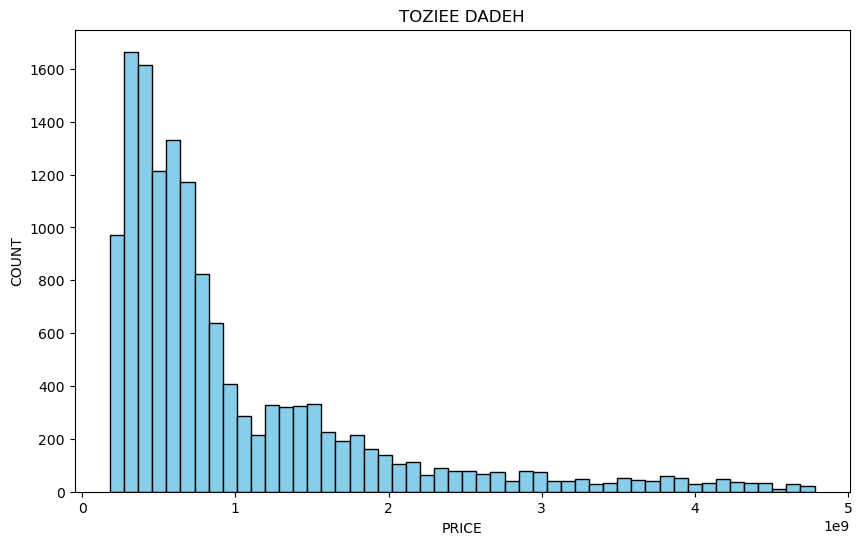

In [77]:
plt.figure(figsize=(10, 6))
plt.hist(y, bins=50, color="skyblue", edgecolor="black")
plt.xlabel("PRICE")
plt.ylabel("COUNT")
plt.title("TOZIEE DADEH")
plt.show()

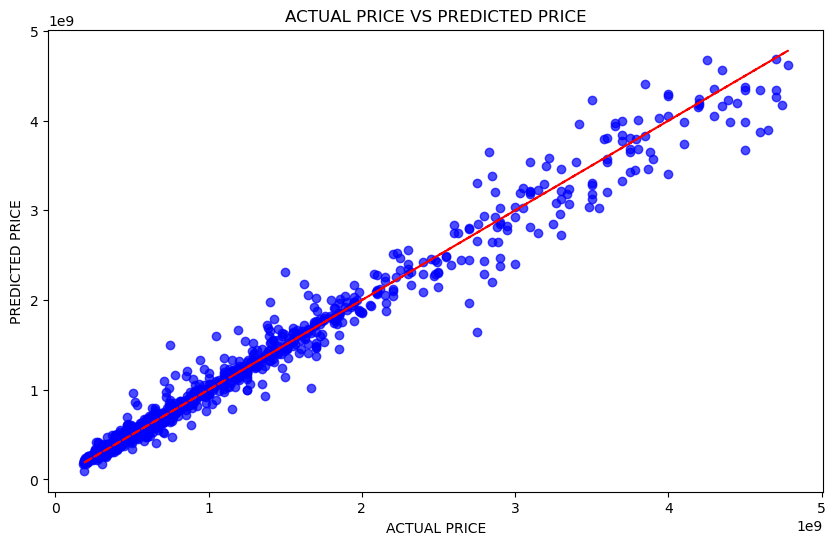

In [78]:
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, color="blue", alpha=0.7)
plt.plot(y_val, y_val, color="red", linestyle="--")  
plt.xlabel("ACTUAL PRICE")
plt.ylabel("PREDICTED PRICE")
plt.title("ACTUAL PRICE VS PREDICTED PRICE")
plt.show()